In [14]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from scipy.ndimage import zoom
from sklearn import preprocessing
from glob import glob
import re
import os

In [16]:
def extract_number_from_path(path):
    match = re.search(r'(\d+)\.dcm$', path)
    if match:
        return int(match.group(1))
    return 0

def get_data_for_3d_volumes(data,train_data_cat, path, number_idx):
    
    data_to_merge = data[["patient_id", "series_id"]]
    patient_category = train_data_cat[["patient_id", "any_injury"]]
    
    merged_df = data_to_merge.merge(patient_category, on='patient_id', how='left')
    
    shuffled_data = merged_df.sample(frac=1, random_state=42)
    shuffled_indexes = shuffled_data.index[:number_idx]
    selected_rows = shuffled_data.loc[shuffled_indexes]
    data_to_merge_processed = selected_rows.reset_index()
    
    total_paths = []
    patient_ids = []
    series_ids = []
    category = []
    
    for patient_id in range(len(data_to_merge_processed)):
    
        p_id = str(data_to_merge_processed["patient_id"][patient_id]) + "/" + str(data_to_merge_processed["series_id"][patient_id])
        str_imgs_path = path + p_id + '/'
        patient_img_paths = []

        for file in glob(str_imgs_path + '/*'):
            patient_img_paths.append(file)
        
        
        sorted_file_paths = sorted(patient_img_paths, key=extract_number_from_path)
        total_paths.append(sorted_file_paths)
        patient_ids.append(data_to_merge_processed["patient_id"][patient_id])
        series_ids.append(data_to_merge_processed["series_id"][patient_id])
        category.append(data_to_merge_processed["any_injury"][patient_id])
    
    final_data = pd.DataFrame(list(zip(patient_ids, series_ids, total_paths, category)),
               columns =["Patient_id","Series_id", "Patient_paths", "Patient_category"])
    
    return final_data

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
    return pixel_array

def resize_img(img_paths, target_size=(128, 128)):
    preprocessed_images = []
    for image_path in img_paths: 
        image = pydicom.read_file(image_path)
        image = standardize_pixel_array(image)
        image = cv2.resize(image, target_size)
        image_array = np.array(image)
        preprocessed_images.append(image_array)

    # Create an empty volume array
    volume_shape = (target_size[0], target_size[1], len(preprocessed_images)) 
    volume = np.zeros(volume_shape, dtype=np.float64)
    # Populate the volume with images
    for i, image_array in enumerate(preprocessed_images):
        volume[:,:,i] = image_array
    return volume
    
def change_depth_siz(patient_volume, target_depth=64):
    desired_depth = target_depth
    current_depth = patient_volume.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(patient_volume, (1, 1, depth_factor), mode='nearest')
    return img_new
    
def normalize_volume(resized_volume):
    original_shape = resized_volume.shape
    flattened_image = resized_volume.reshape((-1,))
    scaler = preprocessing.MinMaxScaler()
    normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
    normalized_volume_image = normalized_flattened_image.reshape(original_shape)
    return normalized_volume_image

def generate_processed_data(list_img_paths, list_labels, target_size=(128,128), target_depth=64):

    num_patients = len(list_img_paths)
    height = target_size[0]
    width = target_size[1]
    depth = target_depth

    volume_array = np.zeros((num_patients, height, width, depth), dtype=np.float64)
    labels_array = np.zeros((num_patients), dtype=np.float64)

    print("Initializing data preprocessing with the following dimensions-> Volumes:{} Labels:{}".format(volume_array.shape, labels_array.shape))

    for i, list_paths in enumerate(list_img_paths):

        resized_images = resize_img(list_paths, target_size=target_size)
        siz_volume = change_depth_siz(resized_images)
        normalized_siz_volume = normalize_volume(siz_volume)

        volume_array[i] = normalized_siz_volume
        labels_array[i] = list_labels[i]
        if (i + 1) % 10 == 0:
            print(f"Iteration {i + 1}: Data Preprocessing running succesfully...")

    return volume_array, labels_array

def generate_patient_processed_data(list_img_paths, list_labels, target_size=(128,128), target_depth=64):

    num_patients = len(list_img_paths)
    height = target_size[0]
    width = target_size[1]
    depth = target_depth

    volume_array = np.zeros((height, width, depth), dtype=np.float64)
    labels_array = np.array(list_labels, dtype=np.float64)

    print("Initializing data preprocessing with the following dimensions-> Volumes:{} Labels:{}".format(volume_array.shape, labels_array.shape))

    resized_images = resize_img(list_img_paths, target_size=target_size)
    siz_volume = change_depth_siz(resized_images)
    normalized_siz_volume = normalize_volume(siz_volume)

    volume_array = normalized_siz_volume

    return volume_array, labels_array

In [18]:
train_data = pd.read_csv(f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
cat_data = pd.read_csv(f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")
path = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
cleaned_df = get_data_for_3d_volumes(train_data, cat_data, path=path, number_idx=50)

In [19]:
cleaned_df

,Patient_id,Series_id,Patient_paths,Patient_category
0,25102,50875,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,1
1,31158,28163,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
2,51177,42398,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
3,56046,38794,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
4,56400,12546,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
5,13646,48080,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
6,54727,27388,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
7,39127,24349,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
8,58475,10924,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
9,21905,58914,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0


In [5]:
for i in range(len(cleaned_df)):
    patient_data_volumes, patient_data_labels = generate_patient_processed_data(cleaned_df["Patient_paths"][i],cleaned_df["Patient_category"][i], target_size=(128,128),target_depth=64)

    with open(f'{str(cleaned_df["Patient_id"][i])}_{str(cleaned_df["Series_id"][i])}.npy', 'wb') as f:
        np.save(f, patient_data_volumes)

Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessin

In [6]:
with open('/kaggle/working/25102_50875.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)
print(X.shape)

(128, 128, 64)


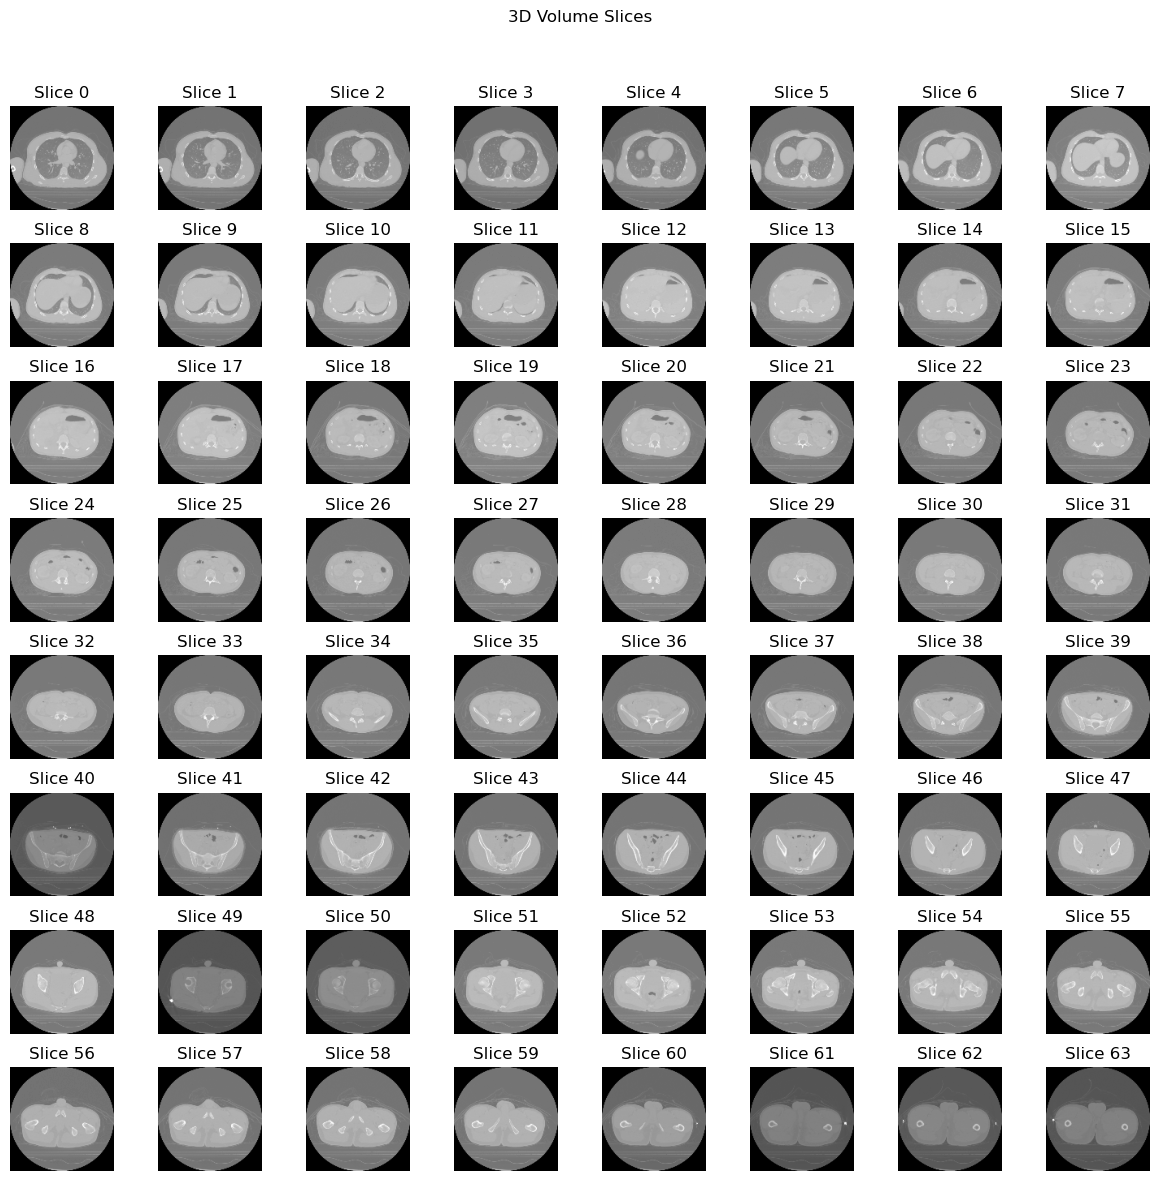

In [20]:
import matplotlib.pyplot as plt
# Create subplots
rows = 8  # Number of rows in the subplot grid
cols = 8  # Number of columns in the subplot grid
depth = 64

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.suptitle('3D Volume Slices')

for d in range(depth):
    row = d // cols
    col = d % cols
    
    ax = axes[row, col]
    ax.imshow(X[:,:,d], cmap='gray')  # You can change the colormap if needed
    ax.set_title(f"Slice {d}")
    ax.axis('off')  # Turn off axis for cleaner visualization

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the position of the suptitle

# Show the plot
plt.show()

### Data Generator

In [21]:
import tensorflow as tf 
from keras import backend as K
from keras import backend as K
from keras.optimizers import SGD
from keras.models import load_model, Model
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization

In [22]:
import math

class Image3DGenerator(tf.keras.utils.Sequence):

    def __init__(self, patient_set, series_set, category_set, batch_size):
        self.x, self.y = patient_set, category_set
        self.series = series_set
        self.batch_size = batch_size
    
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_of_volumes = []
        for patient in range(len(batch_x)):
            with open(f'/kaggle/working/{self.x[patient]}_{self.series[patient]}.npy', 'rb') as f:
                X = np.load(f, allow_pickle=True)
            batch_of_volumes.append(X)
                
        return np.array(batch_of_volumes, dtype=np.float64), np.array(batch_y, dtype=np.float64)

In [25]:
# 3D CNN MODEL
def convolutional_block_3d(inputs, num_filters):

    x = Conv3D(filters=num_filters, kernel_size=(3,3,3),
    activation="relu")(inputs)
    x = MaxPool3D(pool_size=(2,2,2))(x)
    x = BatchNormalization()(x)

    return x

# function to define the dense block of the network, composed by:
# 2 dense layer with 2 dropout layes in between and one output layer for clasification
def dense_block(flatten_layer):
    dense_layer_1 = Dense(units=512, activation='relu')(flatten_layer)
    dense_layer_1 = Dropout(0.4)(dense_layer_1)

    #dense_layer_2 = Dense(units=256, activation='relu')(dense_layer_1)
    #dense_layer_2 = Dropout(0.4)(dense_layer_2)
    output_layer = Dense(units=2, activation='softmax')(dense_layer_1)

    return output_layer

# Main function to build the 3D Conv Network
def build_3d_network(input_shape):

    input_layer = Input(input_shape)

    x1 = convolutional_block_3d(input_layer, 64)
    x2 = convolutional_block_3d(x1, 64)
    x3 = convolutional_block_3d(x2, 128)
    x4 = convolutional_block_3d(x3, 256)

    flatten_layer = Flatten()(x4)

    output = dense_block(flatten_layer)
    model = Model(inputs=input_layer, outputs=output)

    model.compile(loss='mae',optimizer=SGD(learning_rate=1e-06, momentum=0.99, decay=0.0, nesterov=False), metrics=['acc'])
    
    return model

In [11]:
""""input_shape = (128, 128, 64, 1)

model = build_3d_network(input_shape)
model.summary()"""

'"input_shape = (128, 128, 64, 1)\n\nmodel = build_3d_network(input_shape)\nmodel.summary()'

In [26]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpu)
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [29]:
batch_sizes = [2**n for n in range(1,7)]
input_shape = (128, 128, 64, 1)

for i, batch_size in enumerate(batch_sizes):
    model = build_3d_network(input_shape)
    data_gen = Image3DGenerator(cleaned_df["Patient_id"], cleaned_df["Series_id"], cleaned_df["Patient_category"], batch_size=batch_size)
    try:
        print(f"Trying fit model with batch_size = {batch_size}")
        model.fit(data_gen, epochs=10)
        del model
        del data_gen
        continue
    except tf.errors.ResourceExhaustedError:
        if i < len(batch_sizes) - 1:
            print(f"Resources exhausted with batch_size = {batch_size}, trying now with batch_size = {batch_sizes[i + 1]}")
        else:
            print(f"Resources exhausted with batch_size = {batch_size}, no more batch_sizes to try")
            break
        continue      

Trying fit model with batch_size = 2
Epoch 1/10
25/25 [==============================] - 3s 94ms/step - loss: 0.5000 - acc: 0.5400
Epoch 2/10
25/25 [==============================] - 2s 96ms/step - loss: 0.5000 - acc: 0.4600
Epoch 3/10
25/25 [==============================] - 2s 97ms/step - loss: 0.5000 - acc: 0.4600
Epoch 4/10
25/25 [==============================] - 2s 94ms/step - loss: 0.5000 - acc: 0.5400
Epoch 5/10
25/25 [==============================] - 2s 93ms/step - loss: 0.5000 - acc: 0.6000
Epoch 6/10
25/25 [==============================] - 2s 95ms/step - loss: 0.5000 - acc: 0.5200
Epoch 7/10
25/25 [==============================] - 2s 94ms/step - loss: 0.5000 - acc: 0.5200
Epoch 8/10
25/25 [==============================] - 2s 94ms/step - loss: 0.5000 - acc: 0.5000
Epoch 9/10
25/25 [==============================] - 2s 94ms/step - loss: 0.5000 - acc: 0.5200
Epoch 10/10
25/25 [==============================] - 2s 94ms/step - loss: 0.5000 - acc: 0.5400
Trying fit model with 